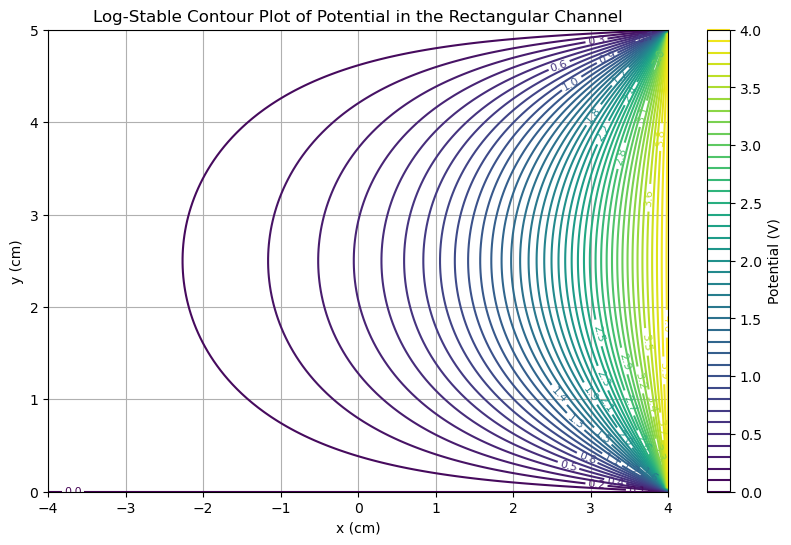

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
V0 = 4.0  # Voltage in Volts
a = 5.0   # cm (distance between plates)
b = 4.0   # cm (length of the channel in x direction)
num_terms = 1001  # Number of terms in the series
x_vals = np.linspace(-b, b, 200)
y_vals = np.linspace(0, a, 100)
X, Y = np.meshgrid(x_vals, y_vals)

# Logarithmic approach to avoid overflow entirely
def log_stable_potential(x, y, num_terms=1001):
    V = np.zeros_like(x)
    for n in range(1, num_terms, 2):  # Summing only odd terms
        n_pi_a = n * np.pi / a
        log_sinh_term_ratio = n_pi_a * (x - b) - np.log1p(-np.exp(-2 * n_pi_a * b))
        sinh_term_ratio = np.exp(log_sinh_term_ratio)
        V += (1 / n) * sinh_term_ratio * np.sin(n_pi_a * y)
    return (4 * V0 / np.pi) * V

# Recompute the potential with the logarithmic approach
V_log_stable = log_stable_potential(X, Y, num_terms=num_terms)

# Plot the contour plot again with the log-stable computation
plt.figure(figsize=(10, 6))
contour = plt.contour(X, Y, V_log_stable, levels=np.arange(0, V0 + 0.1, 0.1), cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8)
plt.colorbar(label='Potential (V)')
plt.title("Log-Stable Contour Plot of Potential in the Rectangular Channel")
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.grid(True)
plt.show()

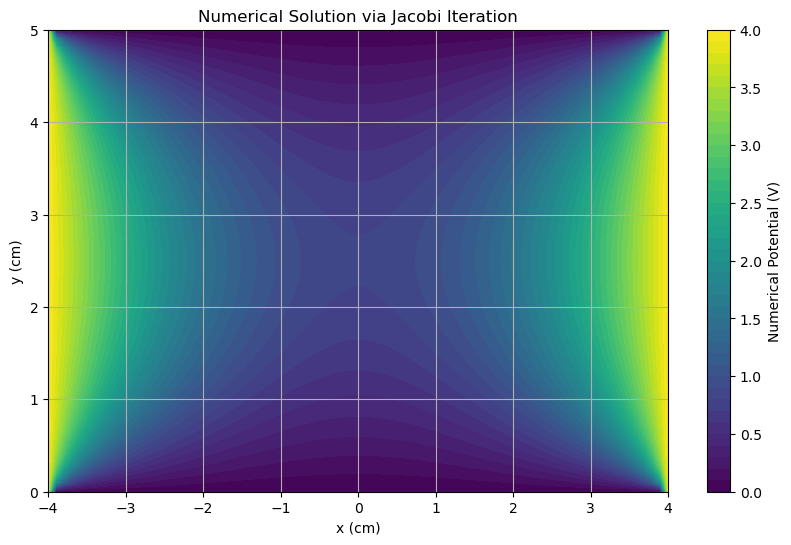

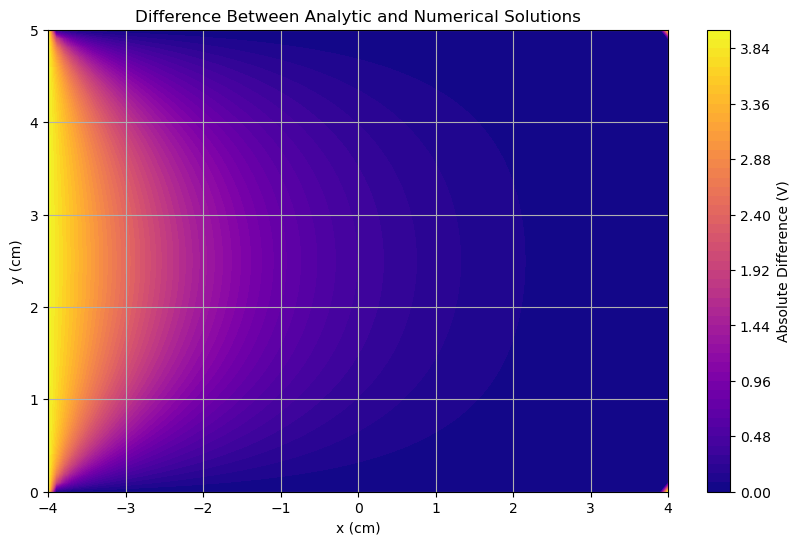

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
a, b = 5.0, 4.0  # Dimensions in cm
V0 = 4.0         # Boundary potential
dx, dy = 0.1, 0.1  # Grid spacing
tol = 1e-5       # Convergence tolerance
max_iter = 10000 # Maximum number of iterations

# Discretize space
nx, ny = int(2 * b / dx) + 1, int(a / dy) + 1
x = np.linspace(-b, b, nx)
y = np.linspace(0, a, ny)
X, Y = np.meshgrid(x, y)

# Initialize potential
V = np.zeros((ny, nx))
V[0, :] = 0  # Bottom plate (y = 0)
V[-1, :] = 0  # Top plate (y = a)
V[:, 0] = V0  # Left strip (x = -b)
V[:, -1] = V0  # Right strip (x = b)

# Jacobi iteration
def jacobi_iteration(V, tol, max_iter):
    V_new = V.copy()
    for _ in range(max_iter):
        for i in range(1, ny - 1):
            for j in range(1, nx - 1):
                V_new[i, j] = 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1])
        # Check convergence
        if np.max(np.abs(V_new - V)) < tol:
            break
        V[:] = V_new[:]
    return V

# Solve numerically
V_numerical = jacobi_iteration(V, tol, max_iter)

V_analytic = log_stable_potential(X, Y)

# Compute the difference
V_difference = np.abs(V_analytic - V_numerical)

# Plot numerical solution
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, V_numerical, levels=np.arange(0, V0 + 0.1, 0.1), cmap='viridis')
plt.colorbar(label='Numerical Potential (V)')
plt.title("Numerical Solution via Jacobi Iteration")
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.grid(True)
plt.show()

# Plot absolute difference
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, V_difference, levels=50, cmap='plasma')
plt.colorbar(label='Absolute Difference (V)')
plt.title("Difference Between Analytic and Numerical Solutions")
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.grid(True)
plt.show()


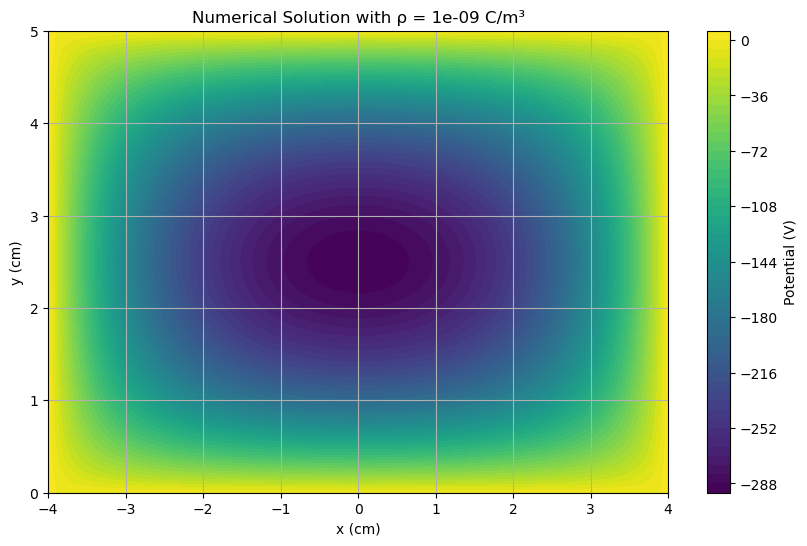

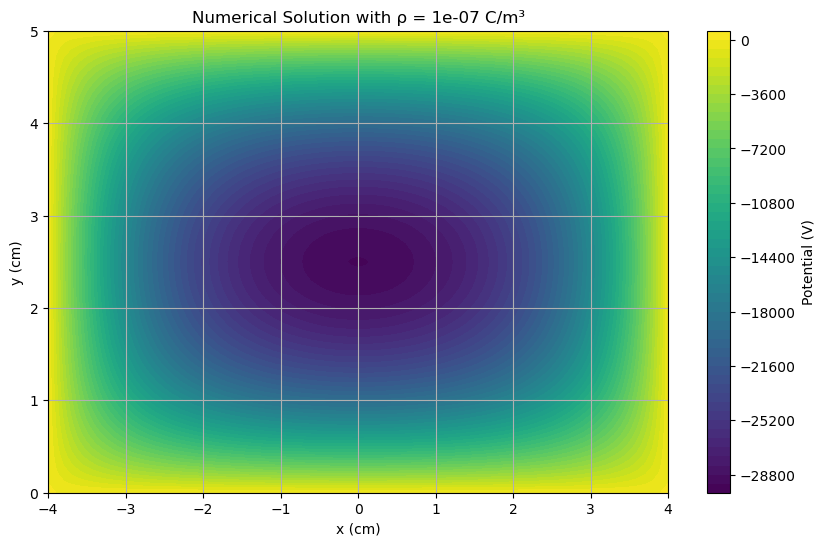

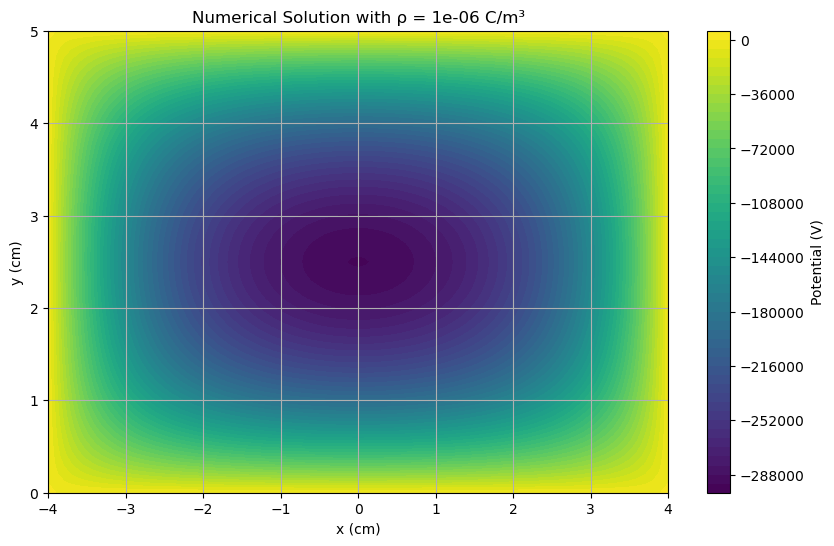

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
a, b = 5.0, 4.0  # Dimensions in cm
V0 = 4.0         # Boundary potential in Volts
dx, dy = 0.1, 0.1  # Grid spacing
rho_values = [1e-9, 1e-7, 1e-6]  # Charge densities in C/m^3
epsilon_0 = 8.854e-12  # Permittivity of free space in F/m
tol = 1e-5       # Convergence tolerance
max_iter = 10000 # Maximum number of iterations

# Discretize space
nx, ny = int(2 * b / dx) + 1, int(a / dy) + 1
x = np.linspace(-b, b, nx)
y = np.linspace(0, a, ny)
X, Y = np.meshgrid(x, y)

# Jacobi iteration with charge density
def jacobi_with_charge(V, rho, dx, dy, tol, max_iter):
    V_new = V.copy()
    factor = dx**2 / epsilon_0
    for _ in range(max_iter):
        for i in range(1, ny - 1):
            for j in range(1, nx - 1):
                V_new[i, j] = 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1] - factor * rho)
        # Check convergence
        if np.max(np.abs(V_new - V)) < tol:
            break
        V[:] = V_new[:]
    return V

# Solve for each charge density
for rho in rho_values:
    # Initialize potential with boundary conditions
    V = np.zeros((ny, nx))
    V[0, :] = 0    # Bottom plate (y = 0)
    V[-1, :] = 0   # Top plate (y = a)
    V[:, 0] = V0   # Left strip (x = -b)
    V[:, -1] = V0  # Right strip (x = b)

    # Solve numerically
    V_solution = jacobi_with_charge(V, rho, dx, dy, tol, max_iter)

    # Plot numerical solution
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, V_solution, levels=50, cmap='viridis')
    plt.colorbar(label='Potential (V)')
    plt.title(f"Numerical Solution with ρ = {rho:.0e} C/m³")
    plt.xlabel("x (cm)")
    plt.ylabel("y (cm)")
    plt.grid(True)
    plt.show()

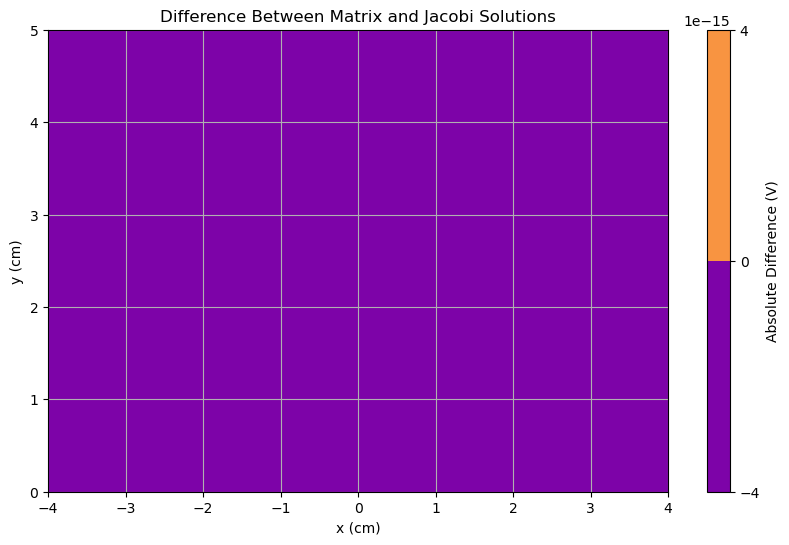

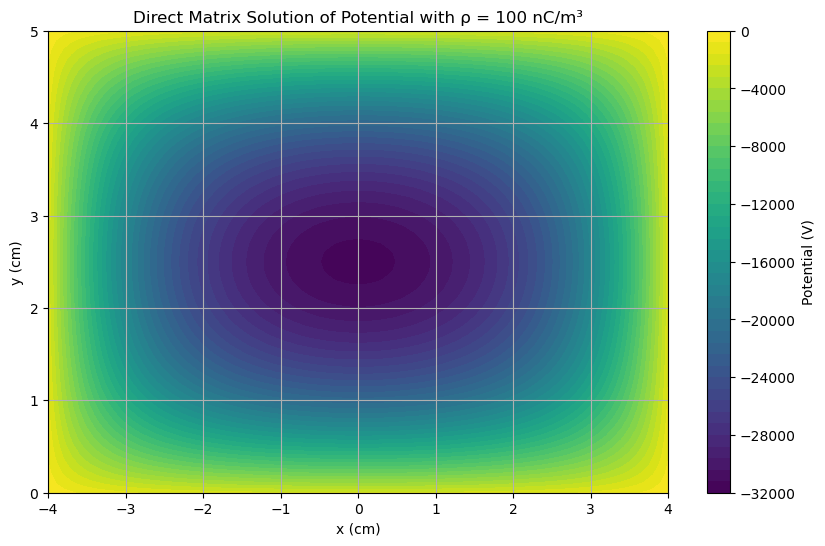

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, linalg

# Parameters
a, b = 5.0, 4.0  # Dimensions in cm
V0 = 4.0         # Boundary potential in Volts
dx = 0.1         # Grid spacing
rho = 100e-9     # Charge density in C/m³
epsilon_0 = 8.854e-12  # Permittivity of free space in F/m

# Discretize space
nx, ny = int(2 * b / dx) + 1, int(a / dx) + 1
x = np.linspace(-b, b, nx)
y = np.linspace(0, a, ny)

# Matrix size
N = nx * ny  # Total number of points

# Construct coefficient matrix A
diagonals = []
main_diag = -4 * np.ones(N)
off_diag = np.ones(N - 1)
far_diag = np.ones(N - nx)

# Account for row boundaries
for i in range(1, ny):
    off_diag[i * nx - 1] = 0

# Build sparse matrix
diagonals.append(main_diag)
diagonals.append(off_diag)
diagonals.append(off_diag)
diagonals.append(far_diag)
diagonals.append(far_diag)
A = diags(diagonals, [0, 1, -1, nx, -nx], format="csr")

# Construct RHS vector b
b = np.zeros(N)
charge_term = (dx**2 * rho) / epsilon_0

for i in range(1, ny - 1):
    for j in range(1, nx - 1):
        idx = i * nx + j
        b[idx] = charge_term

# Apply boundary conditions
for i in range(nx):
    b[i] = 0       # Bottom boundary (y = 0)
    b[(ny - 1) * nx + i] = 0  # Top boundary (y = a)
for i in range(ny):
    b[i * nx] = V0        # Left boundary (x = -b)
    b[i * nx + nx - 1] = V0  # Right boundary (x = b)

# Solve the linear system
V = linalg.spsolve(A, b).reshape((ny, nx))

# Compare with Jacobi solution
V_jacobi = jacobi_with_charge(V, rho, dx, dx, tol=1e-5, max_iter=10000)
difference = np.abs(V - V_jacobi)

# Plot the difference
plt.figure(figsize=(10, 6))
plt.contourf(x, y, difference, levels=50, cmap="plasma")
plt.colorbar(label="Absolute Difference (V)")
plt.title("Difference Between Matrix and Jacobi Solutions")
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.grid(True)
plt.show()


# Plot the result
plt.figure(figsize=(10, 6))
plt.contourf(x, y, V, levels=50, cmap="viridis")
plt.colorbar(label="Potential (V)")
plt.title("Direct Matrix Solution of Potential with ρ = 100 nC/m³")
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.grid(True)
plt.show()
